# Causal Neural Survival Clustering on SEER

In this notebook, we will apply Neural Survival Clustering on the synthetic data obtained from `Synthetic Causal.ipynb`

In [1]:
import sys
sys.path.append('../')
sys.path.append('../DeepSurvivalMachines/')
sys.path.append('../auton-survival/')

### Load the Dataset

In [2]:
from ntc.datasets import load_dataset
import pandas as pd

In [3]:
x, a, t, e, col = load_dataset('SEER')

/home/vincent/Desktop/Thesis/NeuralTreatment/examples/../ntc/datasets.py:30: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + 'export.csv')


In [4]:
x = pd.DataFrame(x, columns = col)
a, t, e = pd.Series(a), pd.Series(t), pd.Series(e)

### Compute horizons at which we evaluate the performance of NSC

Survival predictions are issued at certain time horizons. Here we will evaluate the performance
of DSM to issue predictions at the 25th, 50th and 75th event time quantile as is standard practice in Survival Analysis.

In [5]:
import torch
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
np.random.seed(42)
torch.random.manual_seed(42)

horizons = [0.25, 0.5, 0.75]
times = np.quantile(t[e!=0], horizons).tolist()

In [6]:
# Display the percentage of observed event at different time horizon
for treat in np.unique(a):
    selection = (a == treat)
    print('-' * 42)
    for time in times:
        print('At time {:.2f} months'.format(time))
        for risk in np.unique(e):
            print('\t {:.2f} % observed risk {}'.format(100 * ((e[selection] == risk) & (t[selection] < time)).mean(), risk))
    print('Total')
    for risk in np.unique(e):
        print('\t {:.2f} % observed risk {}'.format(100 * ((e[selection] == risk)).mean(), risk))
              
print('-' * 42)
print('Overall')
for risk in np.unique(e):
    print('\t {:.2f} % observed risk {}'.format(100 * ((e == risk)).mean(), risk))

------------------------------------------
At time 17.00 months
	 4.86 % observed risk 0
	 2.72 % observed risk 1
At time 31.00 months
	 7.64 % observed risk 0
	 4.89 % observed risk 1
At time 48.00 months
	 26.23 % observed risk 0
	 6.84 % observed risk 1
Total
	 91.29 % observed risk 0
	 8.71 % observed risk 1
------------------------------------------
At time 17.00 months
	 2.85 % observed risk 0
	 1.46 % observed risk 1
At time 31.00 months
	 5.17 % observed risk 0
	 3.72 % observed risk 1
At time 48.00 months
	 22.97 % observed risk 0
	 5.99 % observed risk 1
Total
	 91.59 % observed risk 0
	 8.41 % observed risk 1
------------------------------------------
Overall
	 91.45 % observed risk 0
	 8.55 % observed risk 1


### Splitting the data into train, test and validation sets

We will train NSC on 80% of the Data (10 % of which is used for stopping criterion and 10% for model Selection) and report performance on the remaining 20% held out test set.

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(x.index, test_size = 0.2, random_state = 42)
train, val  = train_test_split(train, test_size = 0.2, random_state = 42)
val, dev    = train_test_split(val, test_size = 0.5, random_state = 42)

In [8]:
minmax = lambda x: x / t.loc[train].max() # Enforce to be inferior to 1
t_ddh = minmax(t)
times_ddh = minmax(np.array(times))

### Setting the parameter grid

Lets set up the parameter grid to tune hyper-parameters. We will tune the number of underlying survival distributions, 
($K$), the distribution choices (Log-Normal or Weibull), the learning rate for the Adam optimizer between $1\times10^{-3}$ and $1\times10^{-4}$ and the number of hidden layers between $0, 1$ and $2$.

In [9]:
from sklearn.model_selection import ParameterSampler

In [10]:
layers = [[50, 50], [50, 50, 50]]
param_grid = {
            'learning_rate' : [1e-4],
            'layers_surv': layers,
            'k': [3], # Gamma must be the same otherwise not comparable between different k
            'representation': [10],
            'layers' : layers,
            'act': ['Tanh'],
            'batch': [250],
            }
params = ParameterSampler(param_grid, 3, random_state = 42)

### Model Training and Selection

In [11]:
from ntc import NeuralTreatmentCluster

In [29]:
models = []
for param in params:
    print(param)
    model = NeuralTreatmentCluster(layers = param['layers'], act = param['act'], k = param['k'], correct = False, multihead = False,
                                layers_surv = param['layers_surv'], representation = param['representation'])
    model.fit(x.loc[train].values, t_ddh.loc[train].values, e.loc[train].values, a.loc[train].values, n_iter = 1000, bs = param['batch'],
            lr = param['learning_rate'], val_data = (x.loc[dev].values, t_ddh.loc[dev].values, e.loc[dev].values, a.loc[dev].values))
    nll = model.compute_nll(x.loc[val].values, t_ddh.loc[val].values, e.loc[val].values, a.loc[val].values)
    if not(np.isnan(nll)):
        models.append([nll, model])
    else:
        print("WARNING: Nan Value Observed")

{'representation': 10, 'learning_rate': 0.0001, 'layers_surv': [50, 50, 50], 'layers': [50, 50], 'k': 3, 'batch': 250, 'act': 'Tanh'}


Loss: 0.165 - Training: 0.168 :   2%|▏         | 19/1000 [00:35<30:35,  1.87s/it]


{'representation': 10, 'learning_rate': 0.0001, 'layers_surv': [50, 50, 50], 'layers': [50, 50, 50], 'k': 3, 'batch': 250, 'act': 'Tanh'}


Loss: 0.167 - Training: 0.170 :   2%|▏         | 18/1000 [00:37<34:05,  2.08s/it]


{'representation': 10, 'learning_rate': 0.0001, 'layers_surv': [50, 50], 'layers': [50, 50], 'k': 3, 'batch': 250, 'act': 'Tanh'}


Loss: 0.162 - Training: 0.164 :   2%|▏         | 21/1000 [00:33<26:23,  1.62s/it]


Discrimination should be 0 when negative gamma as it is possible to predict it given the covariates

In [25]:
best_model = min(models, key = lambda x: x[0])
model = best_model[1]

### Evaluation

We evaluate the performance of NTC in its discriminative ability (Time Dependent Concordance Index and Cumulative Dynamic AUC) as well as Brier Score on both the **factual** distribution.

In [26]:
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

In [27]:
# Factual loss
out_survival = model.predict_survival(x.loc[test].values, times_ddh.tolist(), a.loc[test].values)
out_risk = 1 - out_survival

# Evaluation in the context of competing risks
et_train = np.array([(e.loc[i] == 1, t.loc[i]) for i in train],
                dtype = [('e', bool), ('t', float)])
et_test = np.array([(e.loc[i] == 1, t.loc[i]) for i in test],
                dtype = [('e', bool), ('t', float)])
selection = (t.loc[test] < t.loc[train].max())

cis = []
for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test[selection], out_risk[:, i][selection], times[i])[0])
brs = brier_score(et_train, et_test[selection], out_survival[selection], times)[1]
roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test[selection], out_risk[:, i][selection], times[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[horizon[0]])
    print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

For 0.25 quantile,
TD Concordance Index: 0.912351125899806
Brier Score: 0.019072152832075567
ROC AUC  0.9147467957795467 

For 0.5 quantile,
TD Concordance Index: 0.8885684759773592
Brier Score: 0.03718571183579729
ROC AUC  0.8922910016300452 

For 0.75 quantile,
TD Concordance Index: 0.8683622882133084
Brier Score: 0.052925803831917605
ROC AUC  0.874042408035882 



##  Treatment effect evaluation

In this section, we evaluate how good is the treatment estimation

In [16]:
# Extract same eval time than saved rmst
eval_times = np.linspace(0, t.max(), 100)
norm_eval_times = minmax(eval_times)
delta = eval_times[1] - eval_times[0]

In [17]:
alphas = pd.DataFrame(model.predict_alphas(x.loc[test].values), index = test)

In [18]:
# Estimates at the same points than RMST and CIF
estimated_survival = pd.concat({treatment: pd.DataFrame(model.predict_survival(x.loc[test].values, norm_eval_times.tolist(), a = value), columns = eval_times, index = test)
                           for value, treatment in enumerate(['untreated', 'treated'])}, axis = 1, names = ['Treatment'])
estimated_cif = 1 - estimated_survival
estimated_rmse = estimated_cif[('untreated',)] - estimated_cif[('treated',)]

estimated_cluster_treatment = pd.DataFrame(model.treatment_effect_cluster(norm_eval_times.tolist()).T, columns = eval_times)

<Axes: xlabel='Time (in years)', ylabel='Survival Probability'>

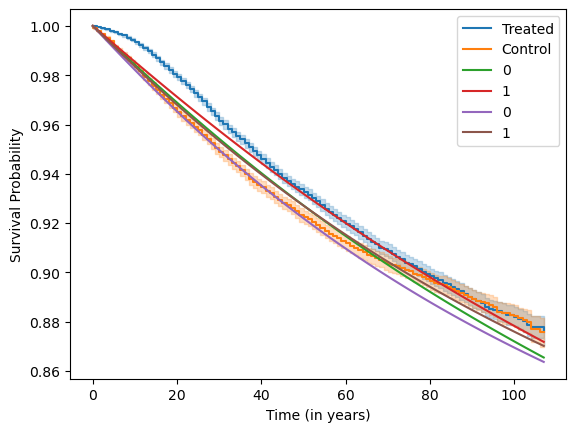

In [19]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
for ai in a.unique():
    kmf = KaplanMeierFitter(label="Treated" if ai == 1 else "Control")
    kmf.fit(t[a == ai], e[a == ai])
    ax = kmf.plot()

plt.xlabel('Time (in years)')
plt.ylabel('Survival Probability')
plt.grid(0.3)
estimated_survival['treated'].groupby(a).mean(1).T.plot(ax = ax, label = 'Treated')
estimated_survival['untreated'].groupby(a).mean(1).T.plot(ax = ax, label = 'Treated')

### Population level

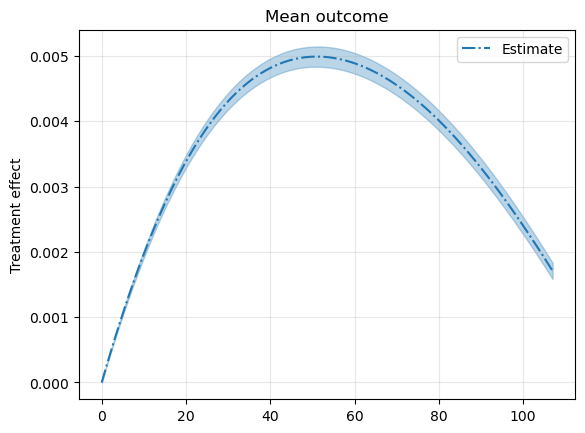

In [20]:
mean, std = estimated_rmse.mean(0), 1.96 * estimated_rmse.std(0) / np.sqrt(len(estimated_rmse))
ax = mean.rename('Estimate').plot(ls = '-.')
plt.fill_between(mean.index, mean + std, mean - std, alpha = 0.3, color = ax.get_lines()[-1].get_color())

plt.ylabel('Treatment effect')
plt.title('Mean outcome')
plt.grid(alpha = 0.3)
plt.legend()
plt.show()

### Feature importance

In [21]:
importance, confidence = model.feature_importance(x.loc[test].values, t.loc[test].values, e.loc[test].values, a.loc[test].values)

  0%|          | 0/100 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
(pd.DataFrame({'Value': 100 * np.array(list(importance.values())), 'Conf': confidence.values()}, index = col)).sort_values('Value').plot.bar(yerr = 'Conf')
plt.ylabel('% change in NLL')
plt.xlabel('Covariates')
plt.grid(alpha = 0.3)

### Cluster level

In [ ]:
x, a, t, e, col = load_dataset('SEER', path = 'data/', standardisation = False)
x = pd.DataFrame(x, columns = col)

In [ ]:
for k in range(model.torch_model.k):
    alphas_max = (alphas.apply(lambda x: x.argmax(), 1) == k)
    ax = estimated_cluster_treatment.loc[k].rename('Cluster {} (n = {}, a = {})'.format(k, alphas_max.sum(), a[test][alphas_max].sum())).plot()
    estimated_rmse[alphas_max].mean(0).rename('Average Effect').plot(ls = '--', color = ax.lines[-1].get_color())
plt.ylabel('Treatment effect')
plt.xlabel('Time (in years)')
plt.grid(alpha = 0.3)
plt.legend()
plt.show()

In [ ]:
from scipy.stats import kruskal
results = x.loc[test].groupby(alphas.loc[test].idxmax(1)).apply(lambda x:  pd.Series(["{:.3f} ({:.3f})".format(mean, std) for mean, std in zip(x.mean(), x.std())], index = x.columns)).T
results['P-Value'] = [kruskal(*[x[col].loc[test][alphas.loc[test].idxmax(1) == i] for i in range(2)]).pvalue for col in results.index]
results.sort_values('P-Value')